# Chap 15 - Ex1: apply GMM to cluster data in data.npy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

np.set_printoptions(suppress = True)
pd.set_option('display.width', 1000)

In [3]:
data = pd.DataFrame(np.load('Data/data.npy'), columns=['Feature_1', 'Feature_2'])
data

,Feature_1,Feature_2
0,2.617559,2.493892
1,1.739570,3.101809
2,3.314142,3.104724
3,1.244302,1.930716
4,3.177270,3.662551
...,...,...
195,2.243348,1.420015
196,0.820143,1.214912
197,1.489568,1.808898
198,2.374414,0.744661


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  200 non-null    float64
 1   Feature_2  200 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


In [6]:
data.describe()

,Feature_1,Feature_2
count,200.000000,200.000000
mean,2.353935,2.262605
std,1.148300,1.229156
min,-0.336247,-0.596964
25%,1.548711,1.395413
50%,2.333212,2.276916
75%,3.130912,3.229444
max,4.975605,5.710737


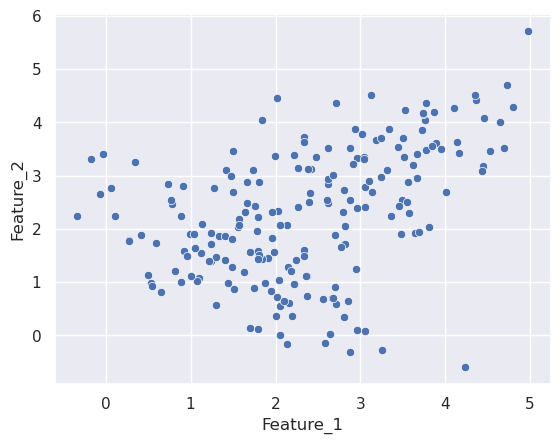

In [16]:
sbn.scatterplot(data = data, x = 'Feature_1', y = 'Feature_2')
plt.show()

## <span style = 'color:yellow'> Check for normality and outliers

Shapiro test of Feature_1: ShapiroResult(statistic=0.9927150879739316, pvalue=0.4240562415098503)
Shapiro test of Feature_2: ShapiroResult(statistic=0.9900638602950576, pvalue=0.1825605400648564)



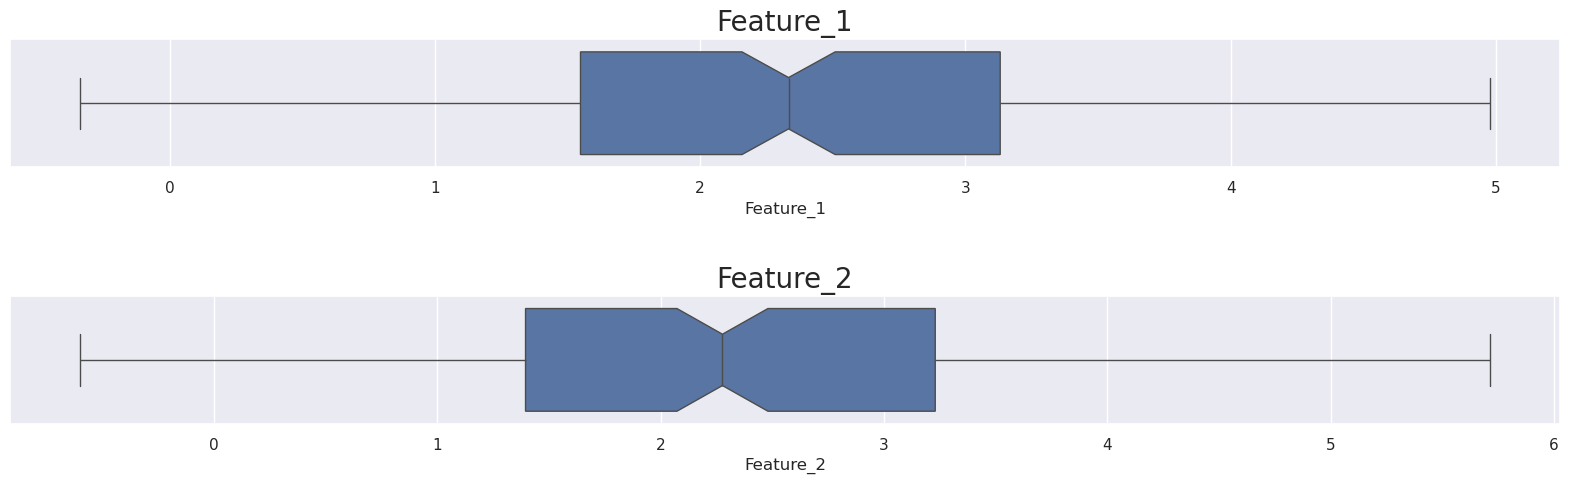

In [15]:
from scipy.stats import shapiro

for i in range(1, len(data.columns)+1):
    print(f'Shapiro test of {data.columns[i-1]}: {shapiro(data.iloc[:, i-1])}')
print()

sbn.set_theme(style='darkgrid')
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2, hspace=1)
for i in range(1, len(data.columns)+1):
    try:
        plt.subplot(2, 1, i)
        sbn.boxplot(data = data, x = data.columns[i-1], notch = True)
        plt.title(data.columns[i-1], size = 20)
    except Exception:
        print('Error {}'.format(data.columns[i-1]))
        break
plt.show()

## <span style = 'color:yellow'> Both features are normally distributed, have no outliers => can use StandardScaler
## <span style = 'color:yellow'> Use Silhoutte Score to find optimal K clusters

Silhouette score for k = 2: 0.4323905287902695
Silhouette score for k = 3: 0.3899846825950486
Silhouette score for k = 4: 0.3751307071204782
Silhouette score for k = 5: 0.355549146418397
Silhouette score for k = 6: 0.3352074222682637
Silhouette score for k = 7: 0.30631064077204945
Silhouette score for k = 8: 0.23985337755630365
Silhouette score for k = 9: 0.21536231091223879


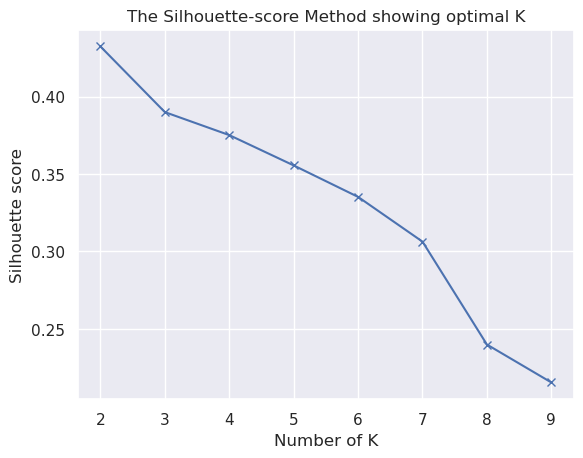

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

silh_score = []
k_nums = range(2,10)

for k in k_nums:
    gmm_pipe = Pipeline([
        ('StandardScaler', StandardScaler()),
        ('GMM', GaussianMixture(n_components = k))
    ])
    gmm_pipe.fit(data)
    data_scaled = (
        data.copy()
        .pipe(lambda df: gmm_pipe.named_steps['StandardScaler'].transform(data))
    )
    labels = gmm_pipe.fit_predict(data)
    print(f'Silhouette score for k = {k}: {silhouette_score(data_scaled, labels)}')
    silh_score.append(silhouette_score(data_scaled, labels))



#Plot the Silhouette Score
plt.plot(k_nums, silh_score, 'bx-')
plt.xlabel('Number of K')
plt.ylabel('Silhouette score')
plt.title('The Silhouette-score Method showing optimal K')
plt.show()

## <span style = 'color:yellow'> Build official GMM with k = 2

     Feature_1  Feature_2  Group
0     2.617559   2.493892      0
1     1.739570   3.101809      0
2     3.314142   3.104724      0
3     1.244302   1.930716      1
4     3.177270   3.662551      0
..         ...        ...    ...
195   2.243348   1.420015      1
196   0.820143   1.214912      1
197   1.489568   1.808898      1
198   2.374414   0.744661      1
199   1.003664   1.110995      1

[200 rows x 3 columns]



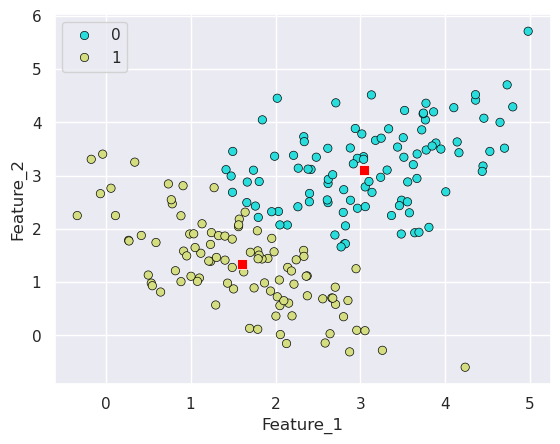

In [37]:
gmm_pipe = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('GMM', GaussianMixture(n_components = 2))
])
gmm_pipe.fit(data)
labels = gmm_pipe.fit_predict(data)

data_group = (
    data.copy()
    .assign(Group = labels)
)

means_inverse = gmm_pipe.named_steps['StandardScaler'].inverse_transform(gmm_pipe.named_steps['GMM'].means_)

print(data_group)
print()

sbn.scatterplot(data = data_group, x = 'Feature_1', y = 'Feature_2', hue = 'Group', palette = 'rainbow', edgecolors = 'black')
sbn.scatterplot(x = means_inverse[:,0], y = means_inverse[:,1], color = 'red', marker = 's', s = 50)
plt.show()